# Sample Time Analysis

In [1]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg

import biopsykit as bp
from biopsykit.stats import StatsPipeline
from biopsykit.io import load_long_format_csv
from biopsykit.utils.dataframe_handling import multi_xs

from fau_colors import cmaps, register_fausans_font

import matplotlib.pyplot as plt
import seaborn as sns

from carwatch_analysis.io import load_cortisol_samples_reporting_times
from carwatch_analysis.datasets import CarWatchDatasetProcessed
from carwatch_analysis.data_processing.sample_times import (
    compute_cumulative_sampling_delay,
    categorize_sampling_adherence,
    compute_max_delay_selfreport
)
from carwatch_analysis.stats import create_unique_night_id, median_iqr_saliva_samples
from carwatch_analysis.plotting import (
    multi_boxplot_sampling_delay,
    multi_paired_plot_sampling_delay,
    sampling_delay_histogram,
)

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties)

theme_kwargs = {"context": "talk", "style": "ticks", "palette": palette}
sns.set_theme(**theme_kwargs)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

export = True

pg.options["round"] = 4

palette

Successfully registered FAU Sans font.


[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Setup Paths

In [3]:
deploy_type = "develop"

In [4]:
# build path to data folder
config_dict = json.load(Path("../../../config.json").open(encoding="utf-8"))
data_path = Path("..").joinpath(config_dict[deploy_type]["base_path"])
data_path

PosixPath('/Users/Richer/Documents/PhD/Projects/HealthPsychology/CARWatch/Data')

In [5]:
dataset = CarWatchDatasetProcessed(data_path)
dataset

,subject,night
0,AB19E,0
1,AB19E,1
2,AB31R,0
3,AB31R,1
4,AC12E,0
...,...,...
229,VE19A,1
230,VS09S,0
231,VS09S,1
232,WM13K,0


In [6]:
base_path = Path("../..")
export_path = base_path.joinpath("exports")
result_path = base_path.joinpath("results")
stats_path = result_path.joinpath("statistics")

img_path = result_path.joinpath("plots")

paper_path = Path(json.load(Path("../paper_path.json").open(encoding="utf-8"))["paper_path"])
paper_img_path = paper_path.joinpath("img")

bp.utils.file_handling.mkdirs([result_path, stats_path, img_path, paper_img_path])

### Cortisol Samples

In [7]:
cort_path = export_path.joinpath("cortisol_samples_processed_all_reporting_types.csv")
cort_samples = load_cortisol_samples_reporting_times(cort_path)
# rename condition for table and plotting
cort_samples = cort_samples.rename({"Spontaneous": "Spontaneous Awakening"}, level="condition")

cort_samples.head()

date  \
subject night night_id condition   reporting_type sample              
AB19E   0     AB19E_0  Known Alarm Naive          S1     2019-11-18   
                                                  S2     2019-11-18   
                                                  S3     2019-11-18   
                                                  S4     2019-11-18   
                                                  S5     2019-11-18   

                                                              wake_onset  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Naive          S1     0 days 05:45:00   
                                                  S2     0 days 05:45:00   
                                                  S3     0 days 05:45:00   
                                                  S4     0 days 05:45:00   
                                                  S5     0 days 05:45:00   

                                                             sample_time  \
subject night night_id condition   reporting_type sample                   
AB19E   0     AB19E_0  Known Alarm Naive          S1     0 days 05:45:00   
                                                  S2     0 days 06:00:00   
                                                  S3     0 days 06:15:00   
                                                  S4     0 days 06:30:00   
                                                  S5     0 days 06:45:00   

                                                          cortisol  \
subject night night_id condition   reporting_type sample             
AB19E   0     AB19E_0  Known Alarm Naive          S1          2.80   
                                                  S2          5.59   
                                                  S3         13.29   
                                                  S4         13.46   
                                                  S5         12.65   

                                                         time_diff_to_wake_onset  \
subject night night_id condition   reporting_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive          S1             0 days 00:00:00   
                                                  S2             0 days 00:15:00   
                                                  S3             0 days 00:30:00   
                                                  S4             0 days 00:45:00   
                                                  S5             0 days 01:00:00   

                                                          time_diff_min  \
subject night night_id condition   reporting_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive          S1                0.0   
                                                  S2               15.0   
                                                  S3               30.0   
                                                  S4               45.0   
                                                  S5               60.0   

                                                          time_diff_to_naive_min  
subject night night_id condition   reporting_type sample                          
AB19E   0     AB19E_0  Known Alarm Naive          S1                         0.0  
                                                  S2                         0.0  
                                                  S3                         0.0  
                                                  S4                         0.0  
                                                  S5                         0.0

In [8]:
conditions = ["Spontaneous Awakening", "Known Alarm", "Unknown Alarm"]
reporting_types_fine = [
    "Naive",
    "AW & ST: Selfreport (without App)",
    "AW & ST: Selfreport (with App)",
    "AW: Sensor, ST: Selfreport (without App)",
    "AW: Sensor, ST: Selfreport (with App)",
    "AW: Sensor, ST: App",
]

reporting_types_coarse = [
    "Naive",
    "AW & ST: Selfreport",
    "AW: Sensor, ST: Selfreport",
    "AW: Sensor, ST: App",
]

reporting_types_fine_rename = [s.replace("without", "w/o").replace("with", "w/") for s in reporting_types_fine]
rename_mapper_reporting_types = dict(zip(reporting_types_fine, reporting_types_fine_rename))

reporting_types_fine = reporting_types_fine_rename

cort_samples = cort_samples.rename(rename_mapper_reporting_types, level="reporting_type")
cort_samples

date  \
subject night night_id condition     reporting_type                      sample              
AB19E   0     AB19E_0  Known Alarm   Naive                               S1     2019-11-18   
                                                                         S2     2019-11-18   
                                                                         S3     2019-11-18   
                                                                         S4     2019-11-18   
                                                                         S5     2019-11-18   
...                                                                                    ...   
WM13K   0     WM13K_0  Unknown Alarm AW: Sensor, ST: Selfreport (w/ App) S1     2019-12-02   
                                                                         S2     2019-12-02   
                                                                         S3     2019-12-02   
                                                                         S4     2019-12-02   
                                                                         S5     2019-12-02   

                                                                                     wake_onset  \
subject night night_id condition     reporting_type                      sample                   
AB19E   0     AB19E_0  Known Alarm   Naive                               S1     0 days 05:45:00   
                                                                         S2     0 days 05:45:00   
                                                                         S3     0 days 05:45:00   
                                                                         S4     0 days 05:45:00   
                                                                         S5     0 days 05:45:00   
...                                                                                         ...   
WM13K   0     WM13K_0  Unknown Alarm AW: Sensor, ST: Selfreport (w/ App) S1     0 days 06:38:13   
                                                                         S2     0 days 06:38:13   
                                                                         S3     0 days 06:38:13   
                                                                         S4     0 days 06:38:13   
                                                                         S5     0 days 06:38:13   

                                                                                    sample_time  \
subject night night_id condition     reporting_type                      sample                   
AB19E   0     AB19E_0  Known Alarm   Naive                               S1     0 days 05:45:00   
                                                                         S2     0 days 06:00:00   
                                                                         S3     0 days 06:15:00   
                                                                         S4     0 days 06:30:00   
                                                                         S5     0 days 06:45:00   
...                                                                                         ...   
WM13K   0     WM13K_0  Unknown Alarm AW: Sensor, ST: Selfreport (w/ App) S1     0 days 06:40:00   
                                                                         S2     0 days 06:55:00   
                                                                         S3     0 days 07:10:00   
                                                                         S4     0 days 07:27:00   
                                                                         S5     0 days 07:42:00   

                                                                                 cortisol  \
subject night night_id condition     reporting_type                      sample             
AB19E   0     AB19E_0  Known Alarm   Naive                               S1          2.80   
        

In [9]:
dict_sample_times = {}

## Sample Times

### All Log Types

#### Median & IQR

In [10]:
variable = "time_diff_to_naive_min"
data_desc = median_iqr_saliva_samples(cort_samples, "time_diff_to_naive_min", ["reporting_type", "sample"])
data_desc = data_desc.reindex(reporting_types_fine[1:])
data_desc.columns = data_desc.columns.set_names(variable, level=-1)
data_desc = data_desc.round(2)
dict_sample_times["Sampling_Delay_Mean_IQR"] = data_desc

data_desc

sample                                   S1           S2           S3        \
time_diff_to_naive_min               median   iqr median   iqr median   iqr   
reporting_type                                                                
AW & ST: Selfreport (w/o App)          1.00  3.00   2.00  5.00   2.00  5.00   
AW & ST: Selfreport (w/ App)           1.00  2.00   1.50  3.00   2.00  4.00   
AW: Sensor, ST: Selfreport (w/o App)   3.90  3.03   4.35  2.88   5.07  3.12   
AW: Sensor, ST: Selfreport (w/ App)    3.76  2.68   3.79  2.78   4.62  2.73   
AW: Sensor, ST: App                    4.34  1.93   5.00  2.10   5.68  2.59   

sample                                   S4           S5        
time_diff_to_naive_min               median   iqr median   iqr  
reporting_type                                                  
AW & ST: Selfreport (w/o App)          2.00  7.00   3.00  8.00  
AW & ST: Selfreport (w/ App)           2.00  3.00   2.00  4.00  
AW: Sensor, ST: Selfreport (w/o App)   5.40  3.38   5.43  3.43  
AW: Sensor, ST: Selfreport (w/ App)    5.18  3.15   5.52  3.05  
AW: Sensor, ST: App                    6.16  2.61   6.63  2.77

#### Cumulative Sampling Delay

In [11]:
cum_sampling_delay = cort_samples["time_diff_to_naive_min"].drop("Naive", level="reporting_type").unstack("sample")
cum_sampling_delay = compute_cumulative_sampling_delay(cum_sampling_delay)
cum_sampling_delay = cum_sampling_delay.reindex(reporting_types_fine[1:]).round(2)
dict_sample_times["Cumulative_Sampling_Delay"] = cum_sampling_delay

cum_sampling_delay

cum_sampling_delay      
                                                 median   iqr
reporting_type                                               
AW & ST: Selfreport (w/o App)                      0.00  4.00
AW & ST: Selfreport (w/ App)                       1.00  2.00
AW: Sensor, ST: Selfreport (w/o App)               0.00  1.00
AW: Sensor, ST: Selfreport (w/ App)                1.00  2.00
AW: Sensor, ST: App                                1.99  1.64

#### Boxplots

#### Paired Plots

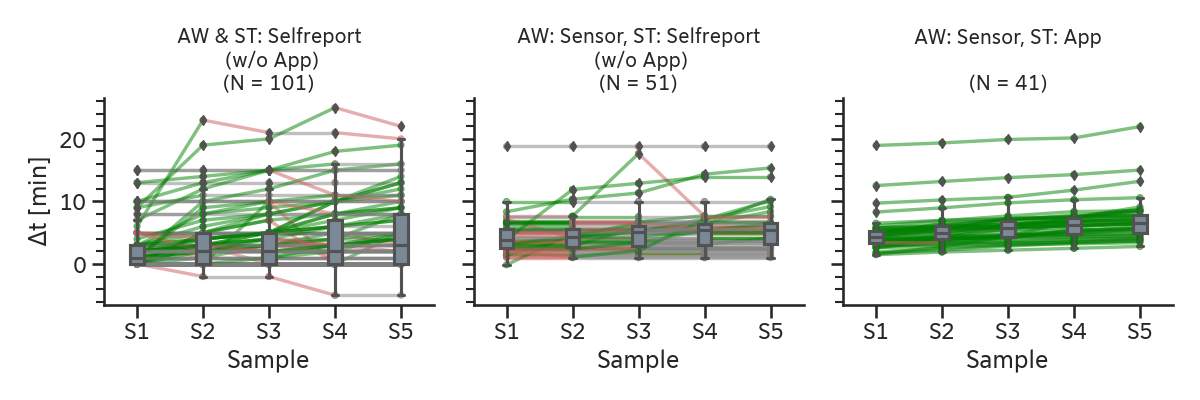

In [12]:
data_plot = cort_samples.copy()

reporting_type_order = reporting_types_fine.copy()
reporting_type_order.remove("Naive")
reporting_type_order.remove("AW & ST: Selfreport (w/ App)")
reporting_type_order.remove("AW: Sensor, ST: Selfreport (w/ App)")

fig, axs = multi_paired_plot_sampling_delay(data_plot, order=reporting_type_order, figsize=(12, 4), dpi=300)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_pairedplot_sampling_delay", path, formats=["png", "pdf"], dpi=300)

#### Compare Highest App-based Sampling Delays with Selfreport Sampling Delays

Get the three CARs with the highest $\Delta t_{S1}$ for *App* (see Paired Plot)

In [13]:
cars_max_delay = cort_samples.xs("AW & ST: App", level="reporting_type")["time_diff_to_naive_min"]
cars_max_delay = cars_max_delay.unstack("sample")["S1"].sort_values(ascending=False).iloc[0:3]
cars_max_delay = list(cars_max_delay.index.get_level_values("night_id"))
print(cars_max_delay)

['MD26R_0', 'KD16N_0', 'WM13K_1']


In [14]:
max_delay_selfreport = compute_max_delay_selfreport(cort_samples, cars_max_delay)
dict_sample_times["Max_Sampling_Delay_SR_App"] = max_delay_selfreport

max_delay_selfreport

sample                                         S1                      \
reporting_type                       AW & ST: App AW & ST: Selfreport   
subject night night_id condition                                        
MD26R   0     MD26R_0  Unknown Alarm        28.07                 2.0   
KD16N   0     KD16N_0  Known Alarm          18.18                 4.0   
WM13K   1     WM13K_1  Unknown Alarm        11.78                 0.0   

sample                                         S2                      \
reporting_type                       AW & ST: App AW & ST: Selfreport   
subject night night_id condition                                        
MD26R   0     MD26R_0  Unknown Alarm        28.32                 2.0   
KD16N   0     KD16N_0  Known Alarm          18.59                 5.0   
WM13K   1     WM13K_1  Unknown Alarm        12.12                 0.0   

sample                                         S3                      \
reporting_type                       AW & ST: App AW & ST: Selfreport   
subject night night_id condition                                        
MD26R   0     MD26R_0  Unknown Alarm        28.42                 2.0   
KD16N   0     KD16N_0  Known Alarm          19.14                 5.0   
WM13K   1     WM13K_1  Unknown Alarm        12.55                 0.0   

sample                                         S4                      \
reporting_type                       AW & ST: App AW & ST: Selfreport   
subject night night_id condition                                        
MD26R   0     MD26R_0  Unknown Alarm        28.96                 2.0   
KD16N   0     KD16N_0  Known Alarm          19.38                 5.0   
WM13K   1     WM13K_1  Unknown Alarm        12.77                 0.0   

sample                                         S5                      
reporting_type                       AW & ST: App AW & ST: Selfreport  
subject night night_id condition                                       
MD26R   0     MD26R_0  Unknown Alarm        29.18                 3.0  
KD16N   0     KD16N_0  Known Alarm          21.20                 5.0  
WM13K   1     WM13K_1  Unknown Alarm        13.26                 0.0

### AW & ST: Selfreport (without App) vs. AW & ST: App

#### By Delay Groups

In [15]:
delay_group_data = cort_samples.reindex(["AW & ST: Selfreport (w/o App)", "AW & ST: App"], level="reporting_type")
delay_group_data = categorize_sampling_adherence(delay_group_data)

delay_group_percent = delay_group_data.groupby("reporting_type").apply(
    lambda df: df.groupby("delay_group").apply(lambda d: len(d) / len(df) * 100)
)
delay_group_percent = delay_group_percent.round(2)
dict_sample_times["Adherence_App_Selfreport"] = delay_group_percent

delay_group_percent

delay_group,Adherent,Non-adherent
reporting_type,,
AW & ST: App,96.25,3.75
AW & ST: Selfreport (w/o App),86.14,13.86


### AW & ST: Selfreport (without App) vs. AW & ST: Selfreport (with App)

#### Data Preparation

In [16]:
cort_samples_selfreport = cort_samples.reindex(
    ["AW & ST: Selfreport (w/o App)", "AW & ST: Selfreport (w/ App)"], level="reporting_type"
)
cort_samples_selfreport.head()

date  \
subject night night_id condition   reporting_type                sample              
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1     2019-11-18   
                                                                 S2     2019-11-18   
                                                                 S3     2019-11-18   
                                                                 S4     2019-11-18   
                                                                 S5     2019-11-18   

                                                                             wake_onset  \
subject night night_id condition   reporting_type                sample                   
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1     0 days 05:45:00   
                                                                 S2     0 days 05:45:00   
                                                                 S3     0 days 05:45:00   
                                                                 S4     0 days 05:45:00   
                                                                 S5     0 days 05:45:00   

                                                                            sample_time  \
subject night night_id condition   reporting_type                sample                   
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1     0 days 06:00:00   
                                                                 S2     0 days 06:15:00   
                                                                 S3     0 days 06:30:00   
                                                                 S4     0 days 06:45:00   
                                                                 S5     0 days 07:01:00   

                                                                         cortisol  \
subject night night_id condition   reporting_type                sample             
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1          2.80   
                                                                 S2          5.59   
                                                                 S3         13.29   
                                                                 S4         13.46   
                                                                 S5         12.65   

                                                                        time_diff_to_wake_onset  \
subject night night_id condition   reporting_type                sample                           
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1             0 days 00:15:00   
                                                                 S2             0 days 00:30:00   
                                                                 S3             0 days 00:45:00   
                                                                 S4             0 days 01:00:00   
                                                                 S5             0 days 01:16:00   

                                                                         time_diff_min  \
subject night night_id condition   reporting_type                sample                  
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1               15.0   
                                                                 S2               30.0   
                                                                 S3               45.0   
                                                                 S4               60.0   
                                                                 S5               76.0   

                                                                         time_diff_to_naive_min  
subject night night_id condition   reporting_type                sample                          
AB19E   0     AB19E_0  Known Alarm AW & ST: Selfreport (w/o App) S1               

#### Boxplot

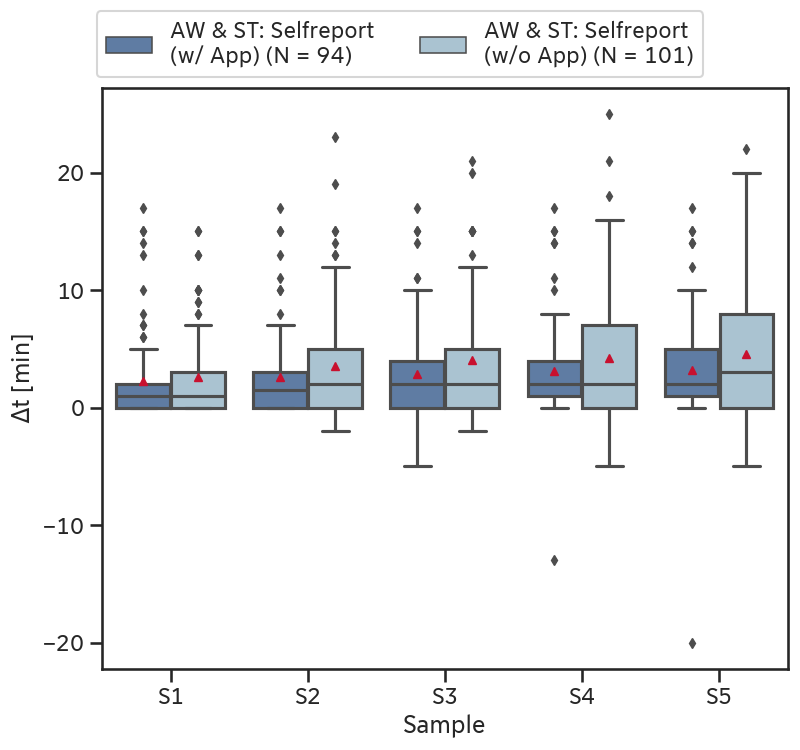

In [17]:
fig, ax = plt.subplots(figsize=(8, 7.5))

num_recordings = dict(
    cort_samples_selfreport.groupby("reporting_type").apply(
        lambda df: len(df.index.get_level_values("night_id").unique())
    )
)

label_mapping = {
    "AW & ST: Selfreport (w/o App)": "AW & ST: Selfreport\n(w/o App)",
    "AW & ST: Selfreport (w/ App)": "AW & ST: Selfreport\n(w/ App)",
}
label_mapping = {key: f"{label_mapping[key]} (N = {num_recordings[key]})" for key in num_recordings}
data_plot = cort_samples_selfreport.rename(index=label_mapping, level="reporting_type")


bp.plotting.feature_boxplot(
    data=data_plot,
    x="sample",
    y="time_diff_to_naive_min",
    hue="reporting_type",
    hue_order=list(label_mapping.values()),
    showmeans=True,
    meanprops={"markeredgecolor": cmaps.wiso[0], "markerfacecolor": cmaps.wiso[0]},
    legend_orientation="horizontal",
    legend_loc="upper center",
    rect=(0, 0, 1, 0.9),
    ax=ax,
    palette=cmaps.faculties_light,
)
ax.set_ylabel("$\Delta t$ [min]")
ax.set_xlabel("Sample")

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_boxplot_sampling_delay_selfreport", path, ["pdf", "png"])

### Sensor

#### Data Preparation

In [18]:
reporting_order = ["AW: Sensor, ST: Selfreport (w/o App)", "AW: Sensor, ST: App"]

data_sensor = multi_xs(cort_samples, reporting_order, level="reporting_type")
data_sensor.head()

date  \
subject night night_id condition   reporting_type                       sample              
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1     2019-11-18   
                                                                        S2     2019-11-18   
                                                                        S3     2019-11-18   
                                                                        S4     2019-11-18   
                                                                        S5     2019-11-18   

                                                                                    wake_onset  \
subject night night_id condition   reporting_type                       sample                   
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1     0 days 05:56:52   
                                                                        S2     0 days 05:56:52   
                                                                        S3     0 days 05:56:52   
                                                                        S4     0 days 05:56:52   
                                                                        S5     0 days 05:56:52   

                                                                                   sample_time  \
subject night night_id condition   reporting_type                       sample                   
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1     0 days 06:00:00   
                                                                        S2     0 days 06:15:00   
                                                                        S3     0 days 06:30:00   
                                                                        S4     0 days 06:45:00   
                                                                        S5     0 days 07:01:00   

                                                                                cortisol  \
subject night night_id condition   reporting_type                       sample             
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1          2.80   
                                                                        S2          5.59   
                                                                        S3         13.29   
                                                                        S4         13.46   
                                                                        S5         12.65   

                                                                               time_diff_to_wake_onset  \
subject night night_id condition   reporting_type                       sample                           
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1             0 days 00:03:08   
                                                                        S2             0 days 00:18:08   
                                                                        S3             0 days 00:33:08   
                                                                        S4             0 days 00:48:08   
                                                                        S5             0 days 01:04:08   

                                                                                time_diff_min  \
subject night night_id condition   reporting_type                       sample                  
AB19E   0     AB19E_0  Known Alarm AW: Sensor, ST: Selfreport (w/o App) S1           3.133333   
                                                                        S2          18.133333   
                                                                        S3          33.133333   
                                                                        S4          48.133333   
                                                                        S5          64.13

#### Median & IQR

In [19]:
data_desc = median_iqr_saliva_samples(data_sensor, "time_diff_to_naive_min", ["reporting_type", "sample"])
data_desc.head()

sample                                      S1                  S2            \
                                        median       iqr    median       iqr   
reporting_type                                                                 
AW: Sensor, ST: App                   4.341217  1.926800  4.997267  2.097483   
AW: Sensor, ST: Selfreport (w/o App)  3.900000  3.033333  4.350000  2.875000   

sample                                      S3                  S4           \
                                        median       iqr    median      iqr   
reporting_type                                                                
AW: Sensor, ST: App                   5.679067  2.589533  6.162967  2.61115   
AW: Sensor, ST: Selfreport (w/o App)  5.066667  3.125000  5.400000  3.37500   

sample                                      S5           
                                        median      iqr  
reporting_type                                           
AW: Sensor, ST: App                   6.627433  2.76595  
AW: Sensor, ST: Selfreport (w/o App)  5.433333  3.42500

#### By Delay Groups

In [20]:
delay_group_data = data_sensor.reindex(reporting_order, level="reporting_type")
delay_group_data = categorize_sampling_adherence(delay_group_data)

delay_group_percent = delay_group_data.groupby("reporting_type").apply(
    lambda df: df.groupby("delay_group").apply(lambda d: len(d) / len(df) * 100)
)
delay_group_percent = delay_group_percent.round(2)
dict_sample_times["Adherence_Sensor_App_Selfreport"] = delay_group_percent
delay_group_percent

delay_group,Adherent,Non-adherent
reporting_type,,
"AW: Sensor, ST: App",65.85,34.15
"AW: Sensor, ST: Selfreport (w/o App)",60.78,39.22


## Export

In [21]:
bp.io.write_pandas_dict_excel(dict_sample_times, result_path.joinpath("sample_time_results.xlsx"))